In [68]:
#Step 0 Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


####Descripción del problema

El banco portugués está teniendo una disminución en sus ingresos, por lo que quieren poder identificar a los clientes existentes que tienen una mayor probabilidad de contratar un depósito a largo plazo. Esto permitirá que el banco centre sus esfuerzos de marketing en esos clientes y evitará perder dinero y tiempo en clientes que probablemente no se suscribirán.

Para abordar este problema crearemos un algoritmo de clasificación que ayude a predecir si un cliente contratará o no un depósito a largo plazo.

In [69]:
#Step 1 Load data

url='https://storage.googleapis.com/breathecode/project-files/bank-marketing-campaign-data.csv'
df_raw = pd.read_csv(url, sep=';')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [70]:
df_raw.sample(10, random_state=2025)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
4479,58,retired,married,basic.4y,unknown,no,no,telephone,may,tue,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,yes
24230,51,entrepreneur,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
8307,43,admin.,married,high.school,no,yes,no,telephone,jun,tue,...,2,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,no
4824,31,admin.,married,high.school,no,no,no,telephone,may,wed,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no
12201,41,blue-collar,married,basic.6y,no,no,no,telephone,jul,wed,...,5,999,0,nonexistent,1.4,93.918,-42.7,4.956,5228.1,no
20123,36,housemaid,married,basic.6y,no,no,no,cellular,aug,mon,...,2,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
11995,44,admin.,married,university.degree,unknown,yes,yes,telephone,jun,thu,...,4,999,0,nonexistent,1.4,94.465,-41.8,4.955,5228.1,no
9514,45,admin.,married,university.degree,no,yes,no,telephone,jun,mon,...,5,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,no
20217,48,entrepreneur,married,university.degree,no,yes,no,cellular,aug,mon,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
8739,22,services,single,high.school,no,no,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,no


In [71]:
#Step 2 Preprocessing.
df_baking = df_raw.copy()
df_baking.columns = df_baking.columns.str.lower()
df_baking['education'] = df_baking['education'].str.replace('.','-')
str_col = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome','y']

df_baking[str_col] = df_baking[str_col].astype("category")

drop_cl = ['duration']
df_baking = df_baking.drop(columns = drop_cl)

df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             41188 non-null  int64   
 1   job             41188 non-null  category
 2   marital         41188 non-null  category
 3   education       41188 non-null  category
 4   default         41188 non-null  category
 5   housing         41188 non-null  category
 6   loan            41188 non-null  category
 7   contact         41188 non-null  category
 8   month           41188 non-null  category
 9   day_of_week     41188 non-null  category
 10  campaign        41188 non-null  int64   
 11  pdays           41188 non-null  int64   
 12  previous        41188 non-null  int64   
 13  poutcome        41188 non-null  category
 14  emp.var.rate    41188 non-null  float64 
 15  cons.price.idx  41188 non-null  float64 
 16  cons.conf.idx   41188 non-null  float64 
 17  euribor3m   

In [72]:
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
26388,35,technician,married,university-degree,no,yes,no,cellular,nov,thu,1,999,0,nonexistent,-0.1,93.200,-42.0,4.076,5195.8,no
15501,38,entrepreneur,married,basic-9y,no,yes,no,cellular,jul,fri,3,999,0,nonexistent,1.4,93.918,-42.7,4.957,5228.1,no
39357,27,self-employed,single,university-degree,no,no,no,cellular,mar,fri,1,999,0,nonexistent,-1.8,93.369,-34.8,0.636,5008.7,yes
16623,56,management,divorced,high-school,no,no,yes,cellular,jul,wed,3,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,no
3312,35,unemployed,divorced,basic-4y,no,yes,no,telephone,may,thu,1,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no


In [73]:
#Step 3 EDA
df_train, df_test = train_test_split(df, test_size=0.1, random_state=2025)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_train.shape, df_test.shape

((37069, 20), (4119, 20))

In [74]:
display(df_train.describe(include='number').T)
display(df_train.describe(include='category').T)

,count,mean,std,min,25%,50%,75%,max
age,37069.0,39.995414,10.428115,17.000,32.000,38.000,47.000,98.000
campaign,37069.0,2.566403,2.775938,1.000,1.000,2.000,3.000,56.000
pdays,37069.0,962.597885,186.604065,0.000,999.000,999.000,999.000,999.000
previous,37069.0,0.172165,0.493927,0.000,0.000,0.000,0.000,7.000
emp.var.rate,37069.0,0.080283,1.570941,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,37069.0,93.574558,0.578955,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,37069.0,-40.509520,4.629495,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,37069.0,3.620738,1.733785,0.634,1.344,4.857,4.961,5.045
nr.employed,37069.0,5167.049586,72.143569,4963.600,5099.100,5191.000,5228.100,5228.100


,count,unique,top,freq
job,37069,12,admin.,9376
marital,37069,4,married,22400
education,37069,8,university-degree,10947
default,37069,3,no,29340
housing,37069,3,yes,19354
loan,37069,3,no,30549
contact,37069,2,cellular,23523
month,37069,10,may,12399
day_of_week,37069,5,thu,7732
poutcome,37069,3,nonexistent,32028


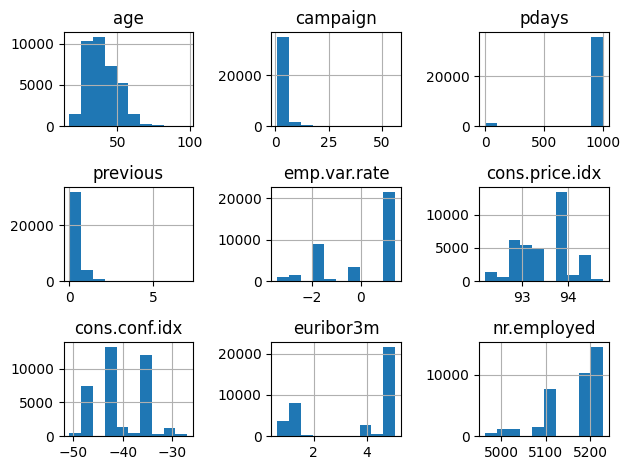

In [75]:
df_train.hist()
plt.tight_layout()
plt.show()

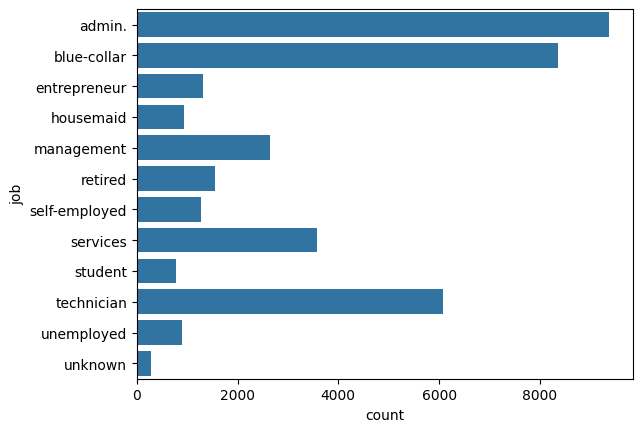

In [76]:
sns.countplot(df_train, y='job')
plt.show()

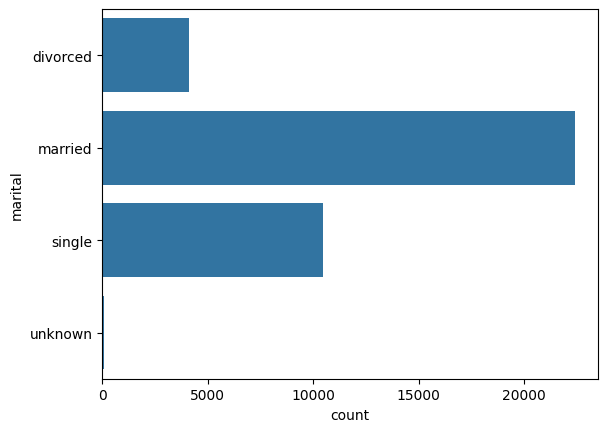

In [77]:
sns.countplot(df_train, y='marital')
plt.show()

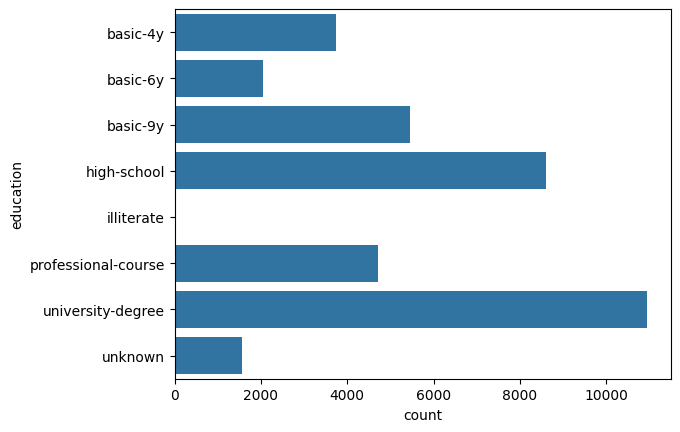

In [78]:
sns.countplot(df_train, y='education')
plt.show()

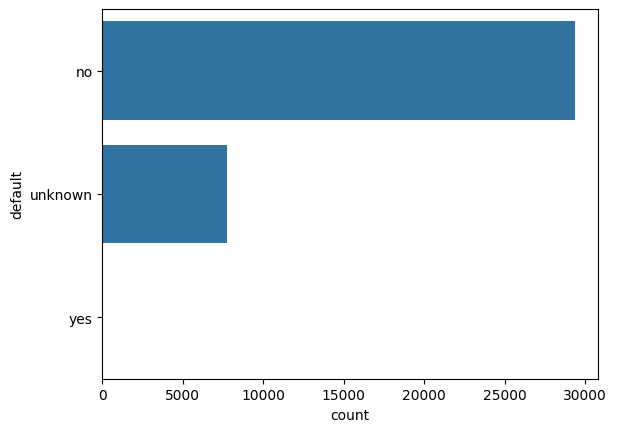

In [79]:
sns.countplot(df_train, y='default')
plt.show()

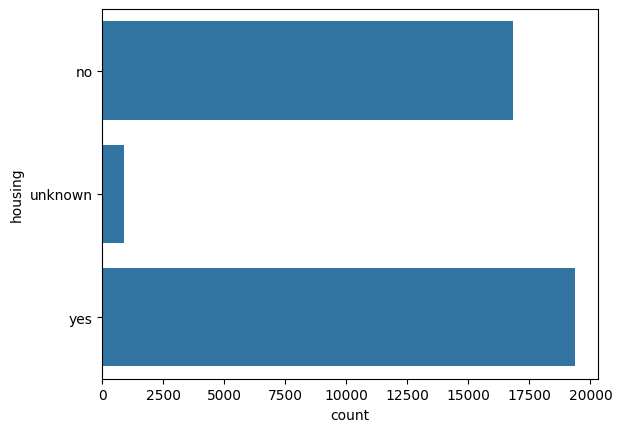

In [80]:
sns.countplot(df_train, y='housing')
plt.show()

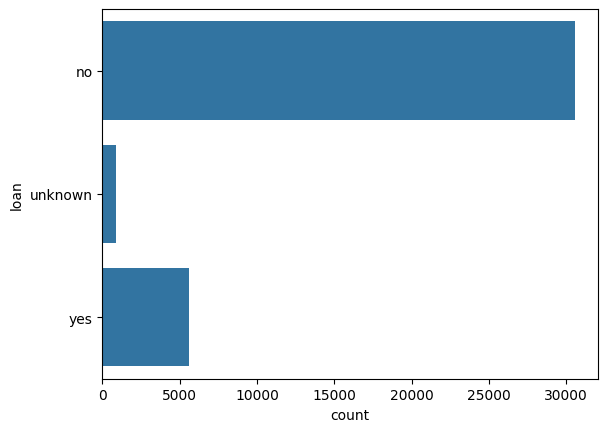

In [81]:
sns.countplot(df_train, y='loan')
plt.show()

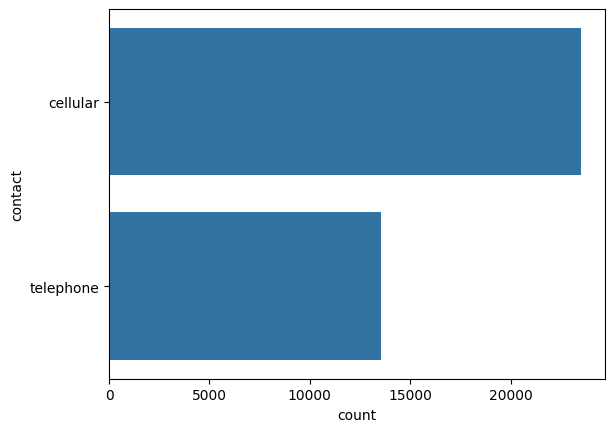

In [82]:
sns.countplot(df_train, y='contact')
plt.show()

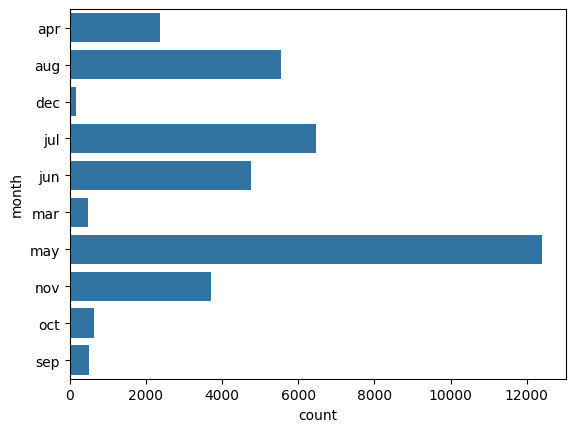

In [83]:
sns.countplot(df_train, y='month')
plt.show()

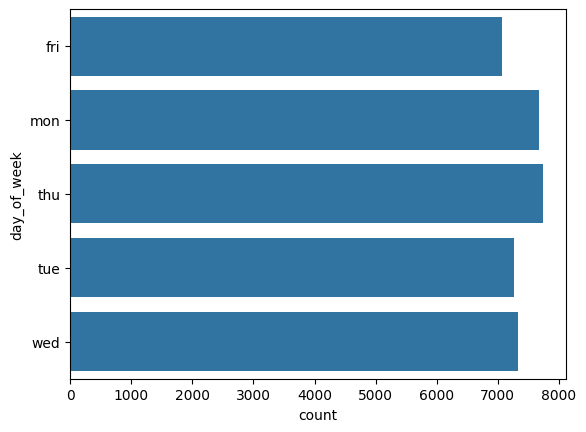

In [84]:
sns.countplot(df_train, y='day_of_week')
plt.show()

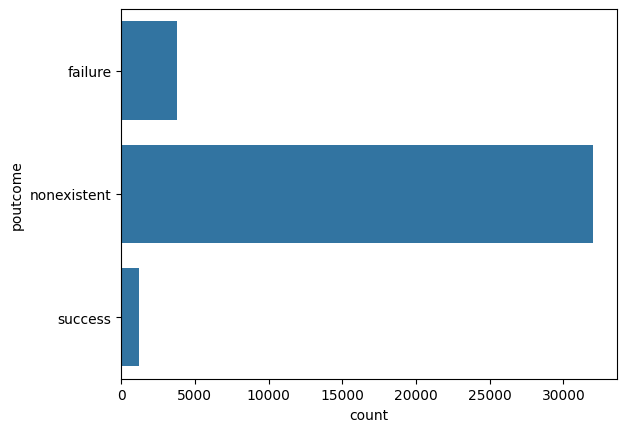

In [85]:
sns.countplot(df_train, y='poutcome')
plt.show()

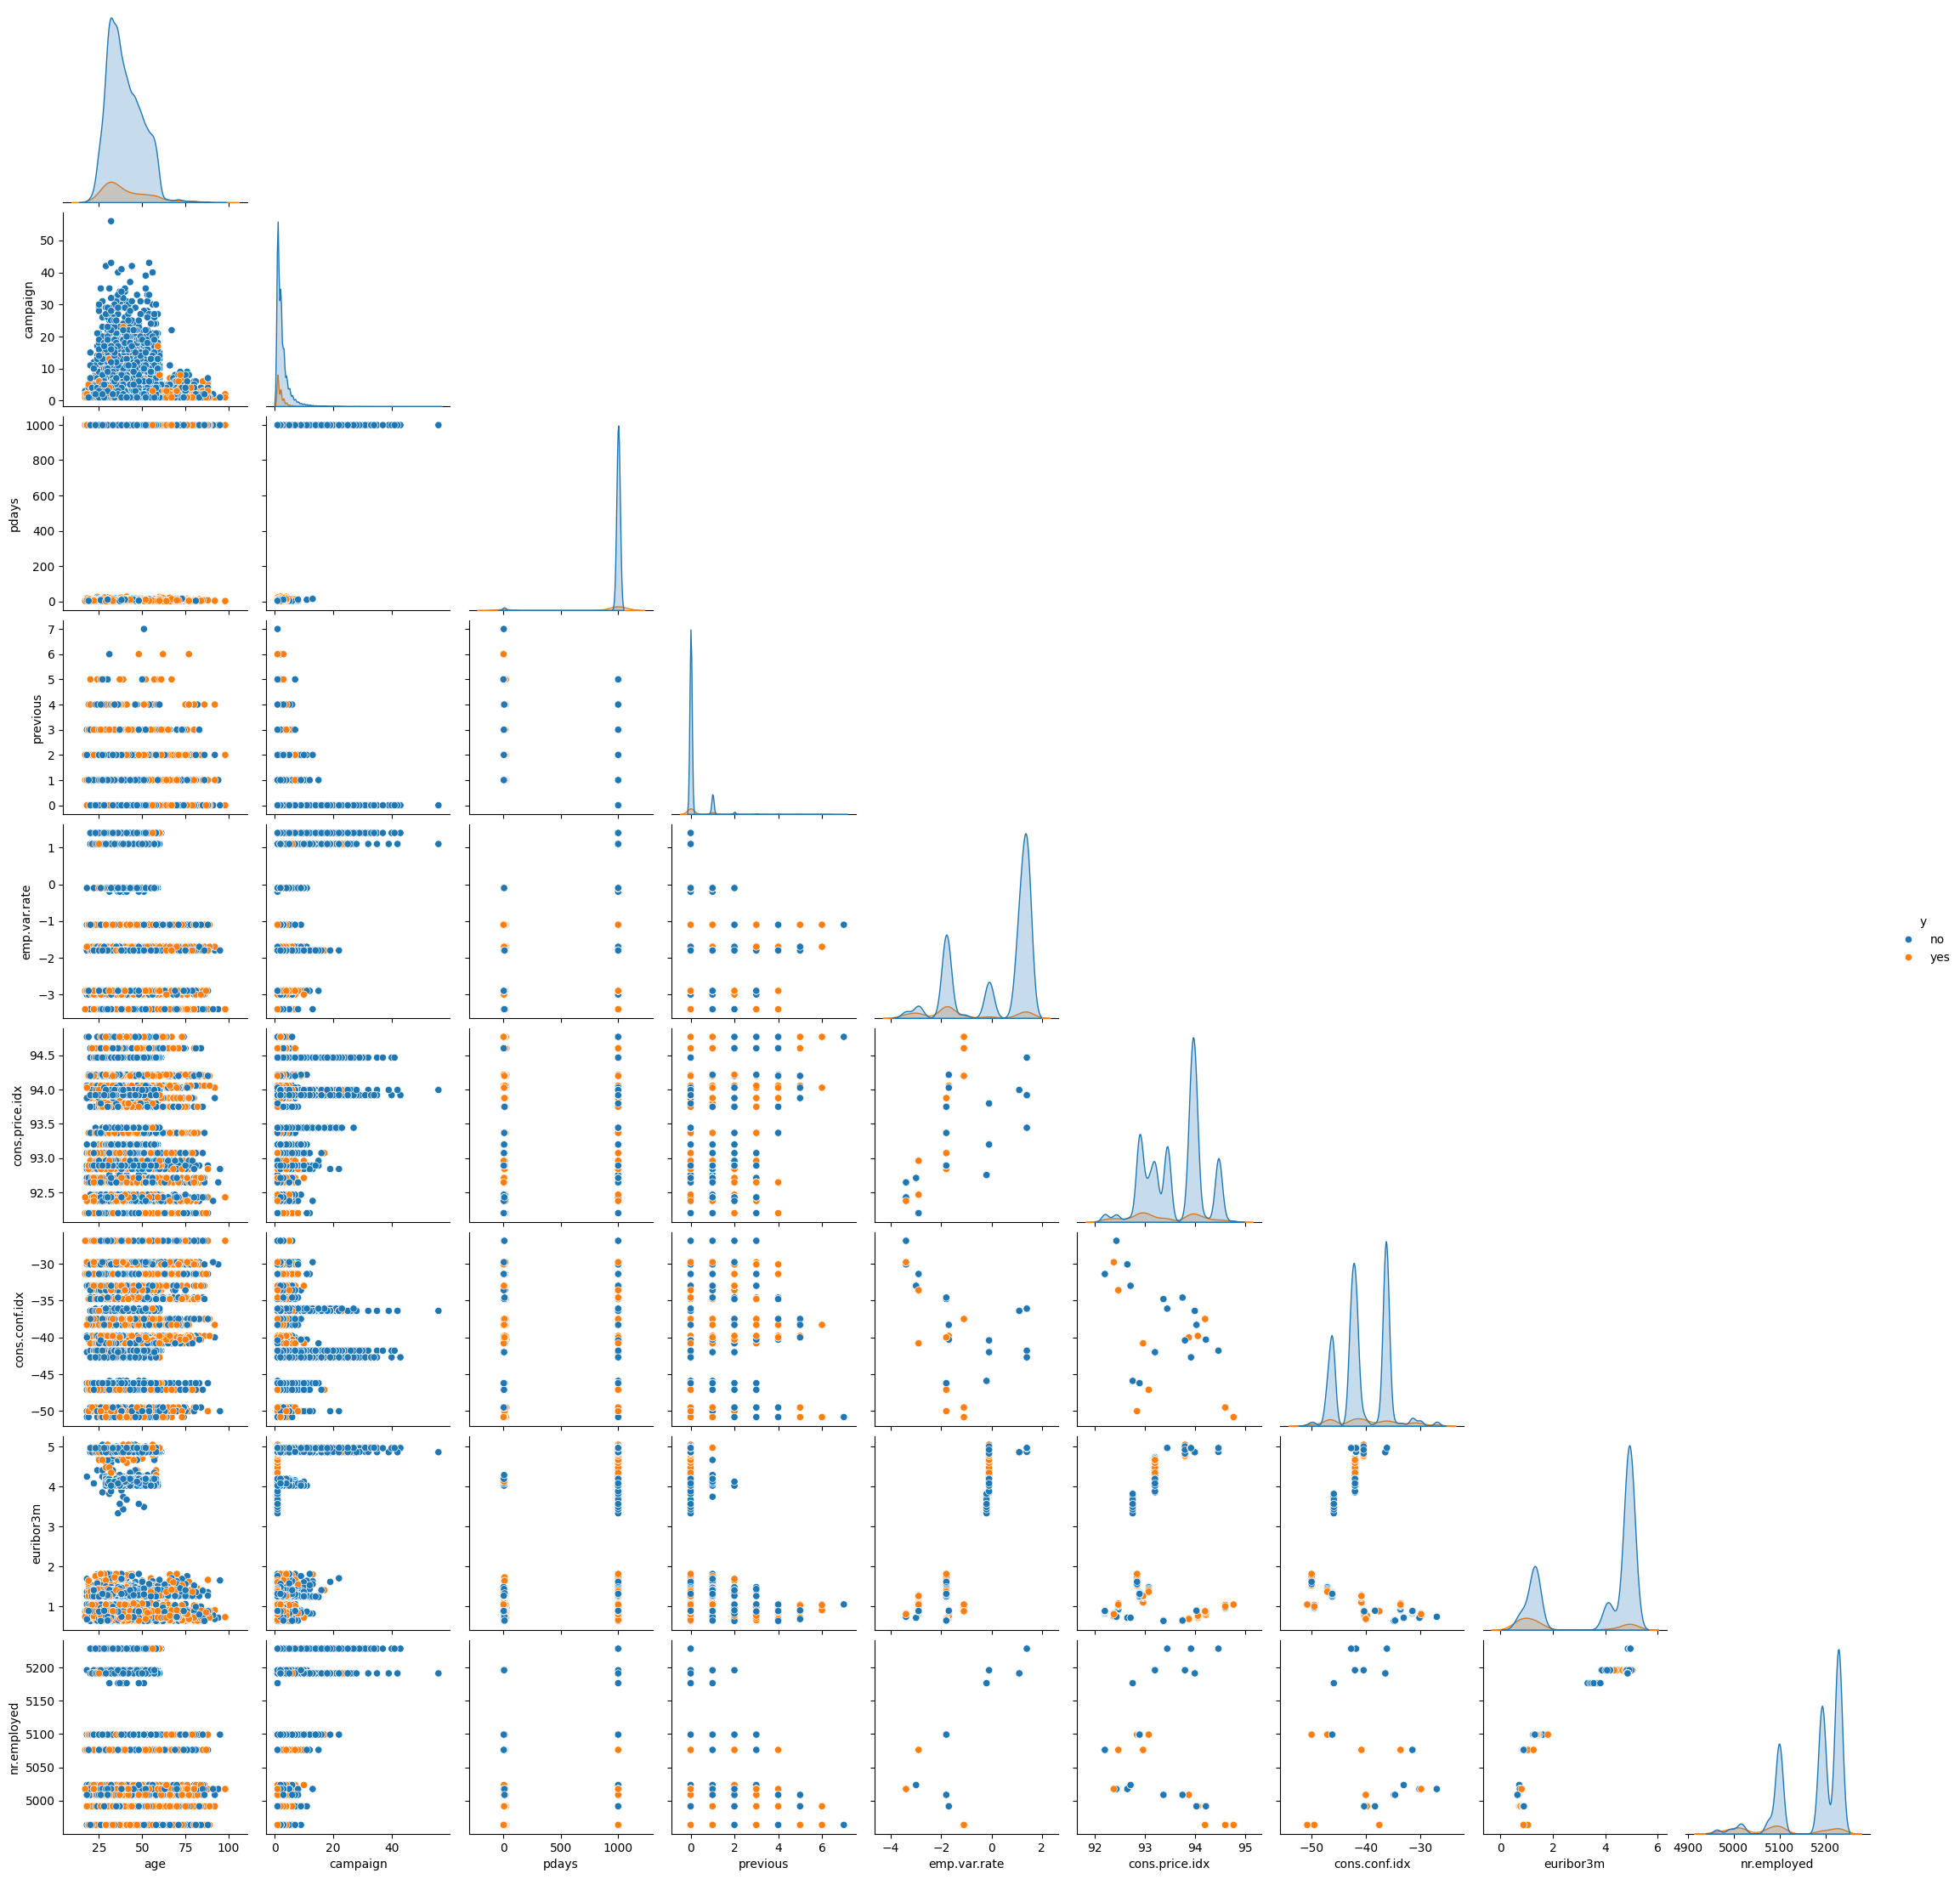

In [86]:
sns.pairplot(df_train, corner=True, hue='y')
plt.show()

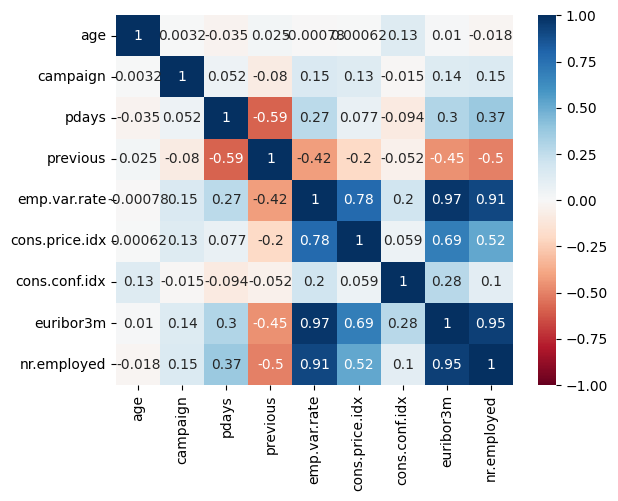

In [87]:
sns.heatmap(df_train.select_dtypes('number').corr(), vmin=-1, vmax=1, cmap='RdBu', annot=True)
plt.show()

In [88]:
#Step 4. ML
X_train = df_train.drop(columns='y')
y_train = df_train['y']
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)

X_test = df_test.drop(columns='y')
y_test = df_test['y']
y_test_enc = label_encoder.transform(y_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((37069, 19), (37069,), (4119, 19), (4119,))

In [89]:
num_cols = X_train.select_dtypes('number').columns
cat_cols = X_train.select_dtypes('category').columns

num_proc = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])
cat_proc = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first',handle_unknown='ignore'))
])
processor = ColumnTransformer(transformers=[
    ('num', num_proc, num_cols),
    ('cat', cat_proc, cat_cols)
])

logis_r = Pipeline(steps=[
    ('proce', processor),
    ('logis_r', LogisticRegression(random_state=42,penalty = "l1", C = 10, solver = "liblinear"))
])

In [90]:
logis_r.fit(X_train, y_train_enc)
y_hat = logis_r.predict(X_test)
y_proba = logis_r.predict_proba(X_test)[:, 1]

print(f'F1 Score: {f1_score(y_test_enc, y_hat):.4f}%')
print(f'Accuracy Score: {accuracy_score(y_test_enc, y_hat):.4f}%')
print(f'AUC-ROC Score: {roc_auc_score(y_test_enc, y_proba):.4f}')


F1 Score: 0.3328%
Accuracy Score: 0.8958%
AUC-ROC Score: 0.8039


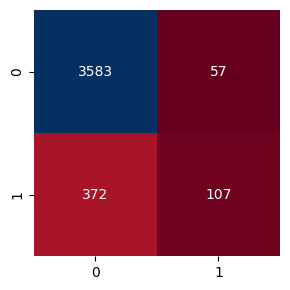

In [91]:
data_cm = confusion_matrix(y_test_enc, y_hat)
cm_df = pd.DataFrame(data_cm)

plt.figure(figsize = (3, 3))
sns.heatmap(cm_df, annot=True, fmt="d", cbar=False, cmap='RdBu')

plt.tight_layout()

plt.show()

3588 (Verdaderos Negativos): El modelo acertó, dijo 'no' y el cliente no contrató.

377 (Falsos Negativos): El modelo dijo 'no', pero el cliente SÍ contrató.

102 (Verdaderos Positivos): El modelo dijo 'sí' y el cliente SÍ contrató.

52 (Falsos Positivos): El modelo dijo 'sí', pero el cliente no contrató.

In [92]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [93]:
hyperparams = {
    "logis_r__C": [0.01, 0.1, 1, 10],
    "logis_r__penalty": ["l1", "l2"],
    "logis_r__solver": ["liblinear"]
}

grid = GridSearchCV(logis_r, hyperparams, scoring="accuracy", cv=5)
grid.fit(X_train, y_train_enc)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('proce',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object'))])),
                                       ('logis_r',
                                        LogisticRegression(C=10, penalty='l1',
                                                           random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'logis_r__C': [0.01, 0.1, 1, 10],
                         'logis_r__penalty': ['l1', 'l2'],
                         'logis_r__solver': ['liblinear']},
             scoring='accuracy')

In [94]:
print(f"Mejores hiperparámetros: {grid.best_params_}")

Mejores hiperparámetros: {'logis_r__C': 10, 'logis_r__penalty': 'l2', 'logis_r__solver': 'liblinear'}
